In [1]:
import numpy as np, h5py
from PIL import Image
import sys
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from utils.processing import *
from utils.template_match_target import *
import os
%matplotlib inline

def pix2coord(x, y, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    long = (x / float(pixbd[0])) * (llbd[1] - llbd[0]) + llbd[0]
    lat = llbd[3] - (y / float(pixbd[1])) * (llbd[3] - llbd[2])
    return long, lat

/Users/silburt/anaconda2/envs/plotting/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Plot crater dists

In [2]:
# Open image, inport crater files
img_global = Image.open('tests/LunarLROLrocKaguya_1180mperpix_downsamp.png').convert("L")  #smaller sized image
#img_global = Image.open('../moon-craters/utils/LunarLROLrocKaguya_118mperpix.png').convert("L")

In [3]:
def get_stats(post_processed, csv_coords, longlat_thresh2=2.6, rad_thresh=1.8, radcut=0):
    #post_processed = pred[pred.T[2] > radcut]
    
    N_match, err_lo, err_la, err_r, beta = 0, 0, 0, 0, 1
    N_csv, N_detect = len(csv_coords), len(post_processed)
    k2d = 180. / (np.pi * 1737.4)       # km to deg
    N_match = 0
    frac_dupes = 0
    N_csv, N_detect = len(csv_coords), len(post_processed)
    new_craters_i, matched_craters_i = [], []
    for i in range(len(post_processed)):
        lo, la, r = post_processed[i]
        Long, Lat, Rad = csv_coords.T
        minr = np.minimum(r, Rad)
        la_m = (la + Lat) / 2.
        
        dL = (((Long - lo) / (minr * k2d / np.cos(np.pi * la_m / 180.)))**2 + ((Lat - la) / (minr * k2d))**2)
        dR = np.abs(Rad - r) / minr
        
        index = (dR < rad_thresh) & (dL < longlat_thresh2)
        index_True = np.where(index == True)[0]
        N = len(index_True)
        if N >= 1:
            matched_craters_i += [i]
            if N > 1:
                min_index = np.argmin(dL + dR**2)
                for j in range(len(index_True)):
                    if index_True[j] != min_index:
                        index[index_True[j]] = False
        else:
            new_craters_i += [i]
        N_match += min(1, N)
        # remove csv(s) so it can't be re-matched again
        csv_coords = csv_coords[np.where(index == False)]
        if len(csv_coords) == 0:
            break
            
    p = float(N_match) / float(N_match + (N_detect - N_match))
    r = float(N_match) / float(N_csv)
    f = (1 + beta**2) * (r * p) / (p * beta**2 + r)
    print("For this image:")
    print("precision: %.3f, recall=%.3f, f1=%.3f"%(p, r, f))
    #print("long_err=%.3f, lat_err=%.3f, rad_err=%.3f"%(err_lo/N_detect, err_la/N_detect, err_r/N_detect))
    print("frac_new_craters=(N_detect-N_match)/N_csv=%.3f"%((N_detect - N_match)/float(N_csv)))
    
    return matched_craters_i, new_craters_i, csv_coords

In [7]:
def coord2pix(long, lat, pixbd, llbd):
    """NEWLY PROGRAMMED"""
    x = (long - llbd[0]) / (llbd[1] - llbd[0]) * pixbd[0]
    y = (llbd[3] - lat) / (llbd[3] - llbd[2]) * pixbd[1]
    return x, y

def cropcraters(craters, llbd):
    return craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                   (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])]

def plot_craters(craters,GT_craters,xc,yc,rawlen,llt2,rt2,mr,i=0,plot_new_only=0):
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='int32')

    img = img_global.crop(box)
    llbd = pix2coord(box[0::2], box[1::2], img_global.size, [-180., 180., -60., 60.])
    #print("longlat bounds:",llbd)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    ctrs_sub = cropcraters(craters, llbd)
    GTctrs_sub = cropcraters(GT_craters, llbd)

    x, y = coord2pix(ctrs_sub.T[0], ctrs_sub.T[1], img.size, llbd)
    r = ctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    GTx, GTy = coord2pix(GTctrs_sub.T[0], GTctrs_sub.T[1], img.size, llbd)
    GTr = GTctrs_sub.T[2]/((llbd[3]-llbd[2])*(np.pi / 180.0)*(1737.4/(box[2]-box[0])))

    #precision/recall/f1 stats
    matched_craters_i, new_craters_i, GT_remain = get_stats(ctrs_sub, GTctrs_sub, llt2, rt2, min(GTctrs_sub.T[2]))
    
    f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=[15, 16])
    plt.tight_layout()
    fontsize = 30
    img = np.asanyarray(img)
    min_, max_ = np.min(img), np.max(img)
    ax1.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax1.set_title('Post-Processed Craters', fontsize=fontsize)
    ax2.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax2.set_title('Ground-Truth Craters', fontsize=fontsize)
    for k in matched_craters_i:
        circle = plt.Circle((x[k], y[k]), r[k], color='blue', fill=False, linewidth=2, alpha=0.5)
        ax1.add_artist(circle)
    for k in new_craters_i:
        circle = plt.Circle((x[k], y[k]), r[k], color='red', fill=False, linewidth=2, alpha=0.5)
        ax1.add_artist(circle)
    for k in range(len(GTctrs_sub)):
        color = 'blue'
        if GTctrs_sub[k] in GT_remain:
            #color = 'fuchsia'
            color = 'darkgreen'
        circle = plt.Circle((GTx[k], GTy[k]), GTr[k], color=color, fill=False, linewidth=2, alpha=0.5)
        ax2.add_artist(circle)
    ax3.imshow(img, cmap='Greys_r', vmin=min_, vmax=max_)
    ax3.set_title('Moon DEM', fontsize=fontsize)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax4.axis('off')
    #plt.savefig('images/llt%s_rt%s_mr%d_xc%d_yc%d_rawlen%d_green.pdf'%(llt,rt,mr,xc,yc,rawlen))
    #plt.close()
    
    return ctrs_sub

In [8]:
# get pred
dtype='test'
llt, rt, mr = '2.60', '1.80', '5'
craters = np.load('datasets/HEAD/HEAD_%s_craterdist_llt%s_rt%s_fin3.npy'%(dtype,llt,rt))

# get GT
truthalan = pd.read_csv('catalogues/LROCCraters.csv')
truthhead = pd.read_csv('catalogues/HeadCraters.csv')
truthhead = truthhead[(truthhead['Lat']>=-60)&(truthhead['Lat']<=60)]
truthalan = truthalan[(truthalan['Lat']>=-60)&(truthalan['Lat']<=60)]
if dtype == 'test':
    truthalan = truthalan[truthalan['Long']>60]        #region of test data
    truthhead = truthhead[(truthhead['Lon']>60)&(truthhead['Diam_km']>20.)]
elif dtype == 'dev':
    truthalan = truthalan[(truthalan['Long']>-60)&(truthalan['Long']<60)]        #region of test data
    truthhead = truthhead[(truthhead['Lon']<60)&(truthhead['Lon']>-60)&(truthhead['Diam_km']>20.)]

rad = np.concatenate((truthalan['Diameter (km)'].values/2.,truthhead['Diam_km'].values/2.))
long = np.concatenate((truthalan['Long'].values,truthhead['Lon'].values))
lat = np.concatenate((truthalan['Lat'].values,truthhead['Lat'].values))

GT_craters = np.column_stack((long, lat, rad))

For this image:
precision: 0.578, recall=0.936, f1=0.715
frac_new_craters=(N_detect-N_match)/N_csv=0.682


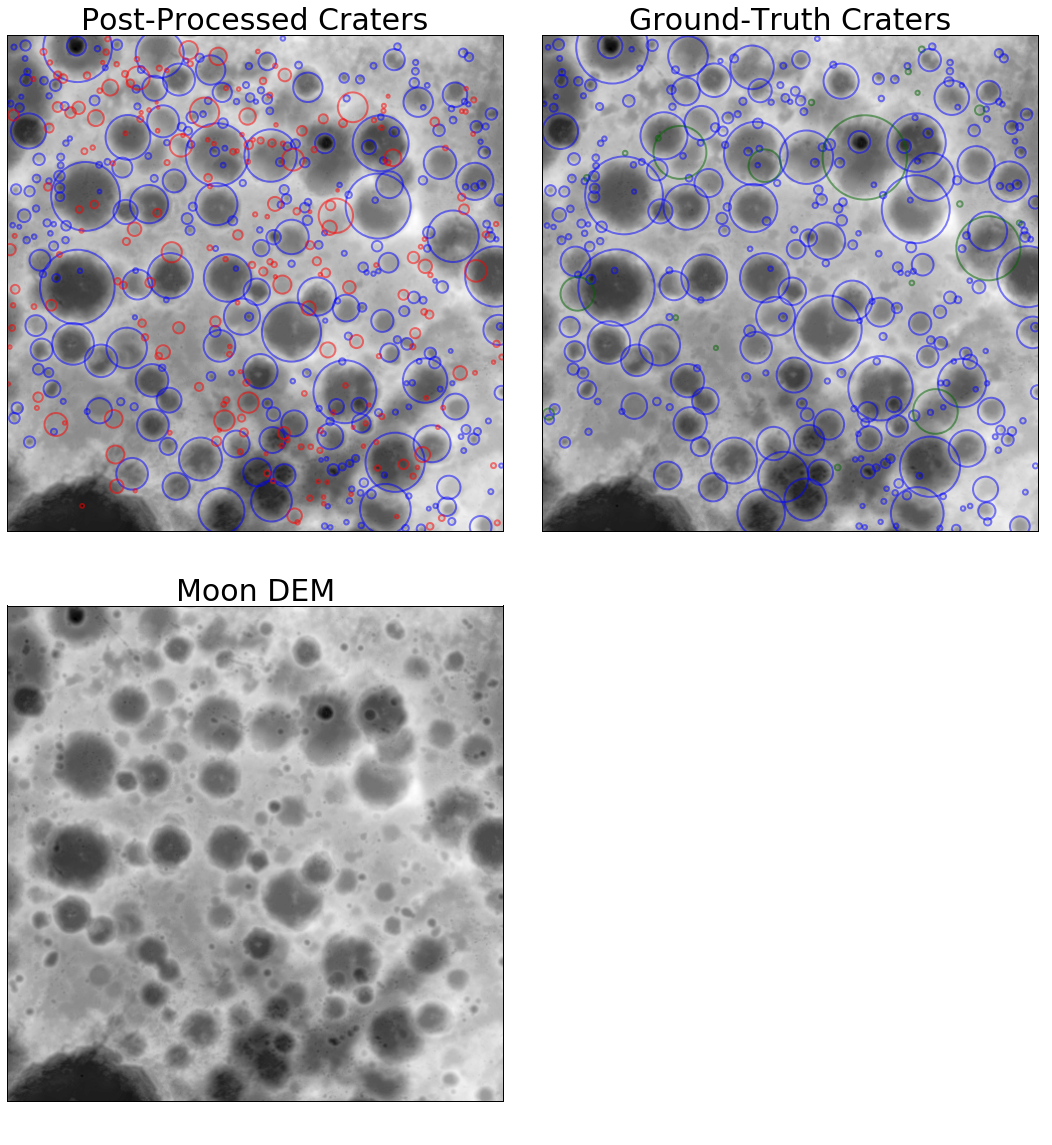

In [10]:
# plot individual, by pixels
#xp,yp,rawlen = 0.6,0.6,500
xp,yp,rawlen = 0.55,0.5,500     #downsampled version
#xp,yp,rawlen = 0.55,0.5,5000      #HQ version

if dtype == 'dev':
    xc = xp*img_global.size[0]/3 + img_global.size[0]/3
elif dtype == 'test':
    xc = xp*img_global.size[0]/3 + 2*img_global.size[0]/3
    
yc = yp*img_global.size[1]
#xc, yc, rawlen = 4608, 1843, 500

ctrs = plot_craters(craters,GT_craters,xc,yc,rawlen,float(llt),float(rt),int(mr))